# make_heatmap_volumes
In this notebook I make the heatmap volumes where the voxel value is the number of brains with an injection at that voxel.

In [33]:
import neuroglancer as ng
import matplotlib,os
import numpy as np
import tifffile
from scipy.ndimage import gaussian_filter, binary_erosion
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
ng.set_static_content_source(url='https://neuroglancer-braincogs.appspot.com')

In [34]:
# Get dicts mapping brain names to primary injection sites
hsv_disynaptic_injection_site_file = '../data/dataframes/thal_cohort_inj_pcoun_data.csv' # HSV-H129_Disynaptic
df_hsv_disynaptic_injection_site = pd.read_csv(hsv_disynaptic_injection_site_file)
hsv_disynaptic_injection_site_dict = df_hsv_disynaptic_injection_site.set_index('brainname')['primary_inj_site'].to_dict()

hsv_trisynaptic_injection_site_file = '../data/dataframes/nc_cohort_inj_pcount_data.csv' # HSV-H129_Trisynaptic
df_hsv_trisynaptic_injection_site = pd.read_csv(hsv_trisynaptic_injection_site_file)
hsv_trisynaptic_injection_site_dict = df_hsv_trisynaptic_injection_site.set_index('brainnames')['primary_inj_site'].to_dict()

prv_disynaptic_injection_site_file = '../data/dataframes/prv_nc_cohort_inj_pcount_data.csv' # PRV Disynaptic
df_prv_disynaptic_injection_site = pd.read_csv(prv_disynaptic_injection_site_file)
prv_disynaptic_injection_site_dict = df_prv_disynaptic_injection_site.set_index('brainname')['primary_inj_site'].to_dict()


In [35]:
dataset_primary_injection_dict = {
    'HSV-H129_Disynaptic':hsv_disynaptic_injection_site_dict,
    'HSV-H129_Trisynaptic':hsv_trisynaptic_injection_site_dict,
    'PRV_Disynaptic':prv_disynaptic_injection_site_dict
}

In [38]:
home_dir = '/home/ahoag/progs/pisano_etal_injections'
viz_dir = os.path.join(home_dir,'precomputed')
datasets = ['HSV-H129_Disynaptic','HSV-H129_Trisynaptic','PRV_Disynaptic']
pma_shape = (540,640,352)
for dataset in datasets:
    print(dataset)
    savename = f'../data/heatmap_volumes/{dataset}_heatmap.tif'
    if os.path.exists(savename):
        print(f"{savename} already exists. Skipping")
        continue
    heatmap_vol = np.zeros(pma_shape)
#     dataset_dir = os.path.join(viz_dir,dataset)
#     sample_names = [x for x in os.listdir(dataset_dir) if x!='progress_dirs' and 'merged' not in x]
    primary_injection_dict = dataset_primary_injection_dict[dataset]
    sample_names = list(primary_injection_dict.keys())
    print(sample_names)
    print(len(sample_names))
    for sample_name in sample_names:
        print(sample_name)
        if dataset in ['HSV-H129_Disynaptic','HSV-H129_Trisynaptic']:
            inj_file = os.path.join(home_dir,'data',dataset,
                f'{sample_name}.tif.tif')
        else:
            inj_file = os.path.join(home_dir,'data',dataset,
                f'{sample_name}.tif')
        
        image = np.array(tifffile.imread(inj_file),dtype=np.uint8, order='F')
        if dataset in ['PRV_Disynaptic']:
            print("Cropping, blurring and eroding")
            # Crop, then blur and erode
            image = image[:,450:,:]
            image = gaussian_filter(image,sigma=1)
            image[image!=0] = 1
            image = binary_erosion(image).astype('uint8')
        z_dim,y_dim,x_dim = image.shape
        voxel_offset_y = 640-y_dim
        posmask = image!=0
        heatmap_vol[:,voxel_offset_y:,:][posmask] += 1
    tifffile.imsave(savename,heatmap_vol.astype('uint8'))
    print(f"Saved {savename}")

HSV-H129_Disynaptic
['20170410_tp_bl6_lob6a_ml_repro_01', '20160823_tp_bl6_cri_500r_02', '20180417_jg59_bl6_cri_03', '20170207_db_bl6_crii_1300r_02', '20160622_db_bl6_unk_01', '20161205_tp_bl6_sim_750r_03', '20180410_jg51_bl6_lob6b_04', '20170419_db_bl6_cri_rpv_53hr', '20170116_tp_bl6_lob6b_lpv_07', '20170411_db_bl6_crii_mid_53hr', '20160822_tp_bl6_crii_1500r_06', '20160920_tp_bl6_lob7_500r_03', '20170207_db_bl6_crii_rpv_01', '20161205_tp_bl6_sim_250r_02', '20161207_db_bl6_lob6a_500r_53hr', '20170130_tp_bl6_sim_rlat_05', '20170115_tp_bl6_lob6b_500r_05', '20170419_db_bl6_cri_mid_53hr', '20161207_db_bl6_lob6a_850r_53hr', '20160622_db_bl6_crii_52hr_01', '20161207_db_bl6_lob6a_50rml_53d5hr', '20161205_tp_bl6_lob45_1000r_01', '20160801_db_l7_cri_01_mid_64hr']
23
20170410_tp_bl6_lob6a_ml_repro_01
20160823_tp_bl6_cri_500r_02
20180417_jg59_bl6_cri_03
20170207_db_bl6_crii_1300r_02
20160622_db_bl6_unk_01
20161205_tp_bl6_sim_750r_03
20180410_jg51_bl6_lob6b_04
20170419_db_bl6_cri_rpv_53hr
20170116

In [3]:
heatmap_vol.dtype

dtype('float64')

In [26]:
np.unique(heatmap_vol)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

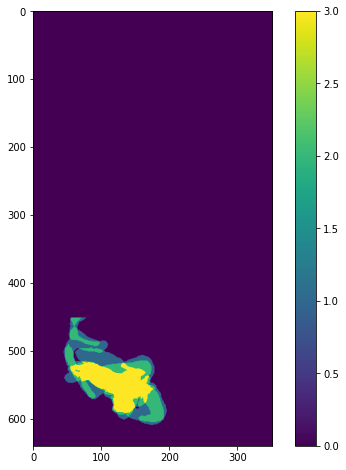

In [27]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
im = ax.imshow(heatmap_vol[240],vmin=0,vmax=3)
cbar = fig.colorbar(im) 

In [28]:
heatmap_file = '../data/heatmap_volumes/HSV-H129_Trisynaptic_heatmap.tif'
heatmap_vol = tifffile.imread(heatmap_file)

In [29]:
np.unique(heatmap_vol)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)